In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
from astropy.time import Time

from mpcq.client import MPCObservationsClient
from mpcq.utils import observations_to_dataframe, submissions_to_dataframe

client = MPCObservationsClient.connect_using_gcloud()

This notebook requires `find_orb` to be installed. `find_orb` is a C/C++ code written by Bill Gray, that calculates an orbit given observations. Its a community favorite and in use by surveys like the Catalina Sky Survey. By default, find_orb will install its executables inside of ~/bin. 

See this [Dockerfile](https://github.com/Bill-Gray/find_orb/blob/master/Dockerfile) for instructions on how to install find_orb. 

In [2]:
object_id = "2012 DA14"

# Query for this object's observations and its submission history
# We will use the submission history to determine the order in which
# observations for this object were found and submitted to the MPC

out_dir = os.path.join("mpc_data", object_id)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

observations_file = os.path.join(out_dir, "observations.parquet")
submissions_file = os.path.join(out_dir, "submissions.parquet")

if not os.path.exists(observations_file):
    observations = client.get_object_observations(object_id)
    observations = observations_to_dataframe(list(observations))
    observations.sort_values(by="timestamp", inplace=True, ignore_index=True)
    observations.to_parquet(observations_file)
else:
    observations = pd.read_parquet(observations_file)

try:
    if not os.path.exists(submissions_file):
        submissions = client.get_object_submissions(object_id)
        submissions = submissions_to_dataframe(list(submissions))
        submissions.sort_values(by="timestamp", inplace=True, ignore_index=True)
        submissions.to_parquet(submissions_file)
    else:
        submissions = pd.read_parquet(submissions_file)
except Exception as e:
    print(f"Failed to get submissions: {e}")
    submissions = None

In [3]:
observations

,mpc_id,status,obscode,filter_band,unpacked_provisional_designation,timestamp,ra,ra_rms,dec,dec_rms,mag,mag_rms,submission_id,created_at,updated_at
0,147501513,Published,J75,V,2012 DA14,2012-02-23 00:40:02,222.40458,None,38.56253,None,18.9,None,2012-02-23T01:48:30.001_00005I8W,2017-07-10,2022-04-10 10:00:51.316625
1,147501514,Published,J75,V,2012 DA14,2012-02-23 00:49:24,222.39471,None,38.58922,None,18.6,None,2012-02-23T01:48:30.001_00005I8W,2017-07-10,2022-04-10 10:00:51.319211
2,147501515,Published,J75,V,2012 DA14,2012-02-23 00:58:47,222.38517,None,38.61608,None,19.0,None,2012-02-23T01:48:30.001_00005I8W,2017-07-10,2022-04-10 10:00:51.321077
3,147501516,Published,J75,V,2012 DA14,2012-02-23 01:37:42,222.34321,None,38.73028,None,18.5,None,2012-02-23T01:59:46.000_00005I8e,2017-07-10,2022-05-26 23:40:55.246733
4,147501517,Published,J75,V,2012 DA14,2012-02-23 01:42:04,222.33850,None,38.74281,None,18.7,None,2012-02-23T01:59:46.000_00005I8e,2017-07-10,2022-05-26 23:40:55.251191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,147502579,Published,J38,R,2012 DA14,2013-02-19 19:43:34,324.17675,None,82.28172,None,17.7,None,2013-02-20T00:58:17.001_00005T8B,2017-07-10,2022-04-10 10:00:53.018948
1064,147502580,Published,J38,R,2012 DA14,2013-02-19 19:46:42,324.18463,None,82.27969,None,17.5,None,2013-02-20T00:58:17.001_00005T8B,2017-07-10,2022-04-10 10:00:53.020260
1065,147502581,Published,J38,R,2012 DA14,2013-02-19 19:48:17,324.18854,None,82.27869,None,17.6,None,2013-02-20T00:58:17.001_00005T8B,2017-07-10,2022-04-10 10:00:53.024245
1066,147502582,Published,C95,R,2012 DA14,2013-02-21 20:02:46,325.79496,None,81.95819,None,18.1,None,2013-07-02T15:12:05.001_00004gIT,2017-07-10,2022-04-10 10:00:53.025921


In [4]:
import subprocess
import os
import tempfile
import json
import shutil
import uuid
import quivr as qv

from adam_core.orbits import Orbits
from adam_core.coordinates import CartesianCoordinates, CoordinateCovariances, Origin
from adam_core.time import Timestamp


class FittedOrbits(qv.Table):
    orbit_id = qv.LargeStringColumn(default= lambda: str(uuid.uuid4()))
    object_id = qv.LargeStringColumn()
    coordinates = CartesianCoordinates.as_column()
    included_observations = qv.Int64Column()
    rejected_observations = qv.Int64Column()
    arc_length = qv.Float64Column()

    def to_orbits(self) -> Orbits:
        return Orbits.from_kwargs(
            orbit_id=self.orbit_id,
            object_id=self.object_id,
            coordinates=self.coordinates,
        )

def observations_to_ades(observations, file_out) -> str:
    """
    Writes observations to a reduced MPC ADES file that can be 
    used with find_orb. 

    """
    ades = observations.rename(columns={
        "unpacked_provisional_designation": "provID",
        "timestamp": "obsTime",
        "ra_rms": "rmsRA",
        "dec_rms": "rmsDec",
        "mag_rms": "rmsMag",
        "filter_band": "band",
        "obscode": "stn",
    })

    column_order = ["provID", "obsTime", "ra", "dec", "mag", "rmsRA", "rmsDec", "rmsMag", "band", "stn"]
    ades = ades[column_order]

    observation_times = Time(
        ades["obsTime"].values,
        format="datetime64",
        scale="utc",
        precision=3,
    )
    ades["obsTime"] = np.array([i + "Z" for i in observation_times.utc.isot])

    # Note not necessarily true for all observations 
    ades["astCat"] = np.full(len(ades), "Gaia2")
    ades["mode"] = np.full(len(ades), "CCD")

    col_header = "|".join(ades.columns) + "\n"

    with open(file_out, "w") as f:
        f.write("# version=2017\n")
        f.write(col_header)

    return ades.to_csv(file_out, index=False, header=False, sep="|", mode="a")

def run_find_orb(observations, out_dir=None):
    """
    Runs find_orb on the given observations and returns the calculated
    orbit and covariance matrix. 

    """
    assert observations["unpacked_provisional_designation"].nunique() == 1

    my_env = os.environ.copy()
    my_env["PATH"] = f"{os.path.expanduser('~/bin')}:{my_env['PATH']}"

    with tempfile.TemporaryDirectory() as tempdir:
        ades_file = os.path.join(tempdir, "ades.psv")
        observations_to_ades(observations, ades_file)

        output = subprocess.run(
            ["fo", ades_file, "-O", tempdir, f"-tEjd{Time(observations['timestamp'].max(), scale='utc').utc.jd}", "-j"],
            capture_output=True,
            text=True,
            env=my_env,
        )

        if output.returncode != 0:
            raise RuntimeError(f"find_orb failed: {output.stderr}")
        
        # Read orbit and covariance from covar.json
        try:
            with open(os.path.join(tempdir, "covar.json")) as f:
                result = json.load(f)
                
                state = np.array(result["state_vect"])
                covariance_matrix = np.array(result["covar"]).reshape(1, 6, 6)
                coords = CartesianCoordinates.from_kwargs(
                    time=Timestamp.from_jd([result["epoch"]], scale="tt"),
                    x=state[0:1],
                    y=state[1:2],
                    z=state[2:3],
                    vx=state[3:4],
                    vy=state[4:5],
                    vz=state[5:],
                    covariance=CoordinateCovariances.from_matrix(covariance_matrix),
                    origin=Origin.from_kwargs(code=["SUN"]),
                    frame="ecliptic",
                )
        
        except FileNotFoundError:
            return FittedOrbits.empty()

        # Read information about the observations used from total.json
        with open(os.path.join(tempdir, "total.json")) as f:
            result_total = json.load(f)

            object_id = observations["unpacked_provisional_designation"].values[0]
            included_observations = result_total["objects"][object_id]["observations"]["used"]
            rejected_observations = result_total["objects"][object_id]["observations"]["count"] - included_observations
            arc_length = result_total["objects"][object_id]["observations"]["latest_used"] - result_total["objects"][object_id]["observations"]["earliest_used"]

        if out_dir is not None:
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            shutil.copytree(tempdir, out_dir)
            shutil.copy(ades_file, out_dir)
        
    return FittedOrbits.from_kwargs(
        object_id=observations["unpacked_provisional_designation"].values[:1], 
        coordinates=coords,
        included_observations=[included_observations],
        rejected_observations=[rejected_observations],
        arc_length=[arc_length],
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:

orbit_fits_dir = os.path.join("orbit_fits", object_id)
if not os.path.exists(orbit_fits_dir):
    os.makedirs(orbit_fits_dir)

def run_object_observations_by_submission(observations, submissions=None):
    """
    Runs find_orb on the observations for a given object, grouped by
    submission. 

    """
    fitted_orbits = []
    submission_ids = []
    last_submission = []

    if submissions is None:
        unique_submission_ids = observations["submission_id"].unique()
    else:
        unique_submission_ids = submissions["id"].unique()

    for i, submission_id in enumerate(unique_submission_ids):
        submission_ids.append(submission_id)
        observations_subset = observations[observations["submission_id"].isin(submission_ids)]
        fitted_orbits_i = run_find_orb(observations_subset)
        if len(fitted_orbits_i) > 0:
            fitted_orbits_i = fitted_orbits_i.set_column("orbit_id", pa.array([f"{i:03d}::{submission_id}"], type=pa.large_string()))

            fitted_orbits.append(fitted_orbits_i)
            last_submission.append(submission_id)
        else:
            print(f"Orbit fit for submissions up to {submission_id} failed.")

    return last_submission, qv.concatenate(fitted_orbits)

orbit_file = os.path.join(orbit_fits_dir, "orbits.parquet")
submission_ids_file = os.path.join(orbit_fits_dir, "submission_ids.txt")

if not os.path.exists(orbit_file):
    last_submission, orbits = run_object_observations_by_submission(observations, submissions)
    orbits.to_parquet(orbit_file)
    np.savetxt(submission_ids_file, last_submission, fmt="%s")

else:
    orbits = FittedOrbits.from_parquet(orbit_file)
    last_submission = np.loadtxt(submission_ids_file, dtype=str)

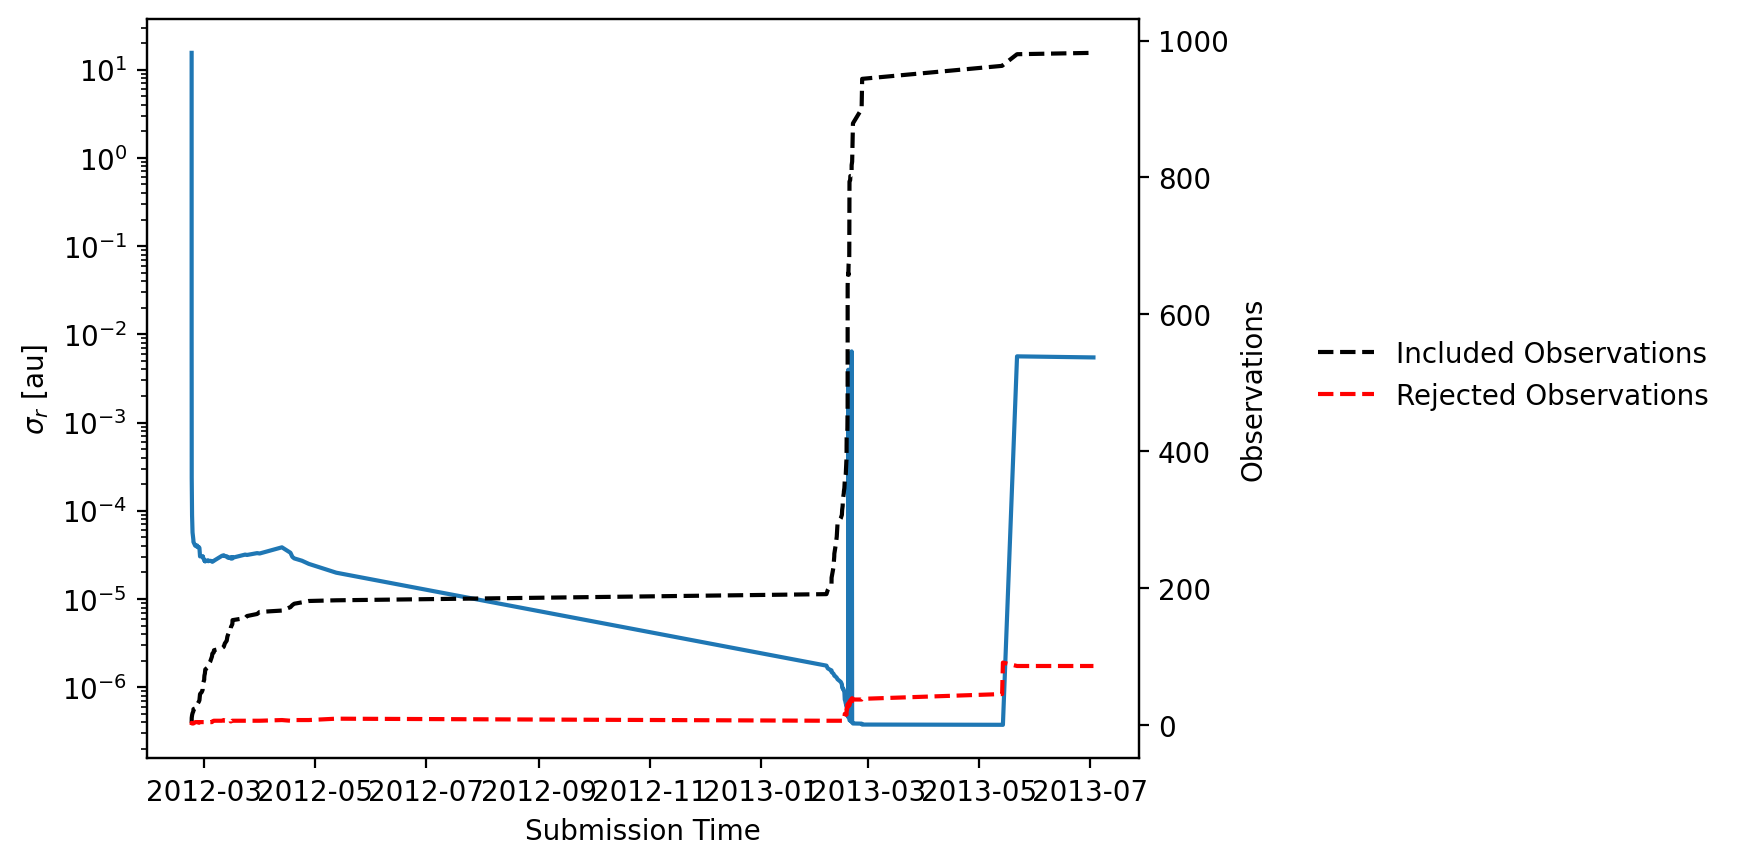

In [6]:
import matplotlib.pyplot as plt

if submissions is None:
    timestamps = observations.groupby(["submission_id"])["timestamp"].max().values
    timestamps.sort()
else:
    timestamps = submissions[submissions["id"].isin(last_submission)]["timestamp"]

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(timestamps, orbits.coordinates.sigma_r_mag)
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma_r$ [au]")
ax.set_xlabel("Submission Time")

ax2 = ax.twinx()
ax2.plot(
    timestamps, 
    orbits.included_observations, 
    c="k", 
    ls="--",
    label="Included Observations"
)
ax2.plot(
    timestamps, 
    orbits.rejected_observations, 
    c="r", 
    ls="--",
    label="Rejected Observations"
)
ax2.set_ylabel("Observations")
ax2.legend(frameon=False, bbox_to_anchor=(1.6, 0.6))